In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr;xr.set_options(display_style='text') 
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import cartopy.crs as ccrs
import cartopy

import sys
p = '/global/homes/q/qnicolas'
if p not in sys.path:
    sys.path.append(p)

from tools.wrfHrTools import *

#from orographicPrecipitation.precip_model_functions import qsat,humidsat
from orographicConvectionTheory.orographicConvectionTheory import *
SCRATCH='/global/cscratch1/sd/qnicolas/'

import dask
import dask.dataframe

from scipy.ndimage import gaussian_filter1d

In [4]:
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status"
from dask.distributed import Client
client=Client(n_workers=8,threads_per_worker=4)#,memory_limit='10GB')
client

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45764 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:39513 Dashboard: /user/qnicolas/perlmutter-shared-node-cpu/proxy/45764/status,Cluster Workers: 8 Cores: 32 Memory: 540.24 GB


In [2]:
class SimulationCustom(Simulation):
    def __init__(self,path,center,dx,suffix2,inp=False,out=False,pout=False,is_subset=False):
        super().__init__(path,center,dx,inp,out,pout,is_subset)
        self.suffix2 = suffix2
        self.RAINNC  = xr.open_zarr(self.path+'wrf.SFCVARS.1h.%s.zarr'%self.suffix2).RAINNC_MMDY
        try:
            self.T_PL_MEAN = xr.open_dataarray(self.path+'wrf.T_PL.%s.mean.nc'%self.suffix2 )
            self.Q_PL_MEAN = xr.open_dataarray(self.path+'wrf.Q_PL.%s.mean.nc'%self.suffix2 )
        except FileNotFoundError:
            pass

W10S300   = SimulationCustom('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/'          ,1635,3,'1970010100-1970072000',inp=True)
W10S300n  = SimulationCustom('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new.3km/'      ,1635,3,'1970010100-1970042600')
W10S300n2 = SimulationCustom('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new2.3km/'     ,1635,3,'1970010100-1972091700')
#W12S300   = SimulationCustom('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/'    ,1635,3,'1970010100-1971010400')
#W12S300n  = SimulationCustom('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.new.3km/',1635,3,'1970010100-1972032100')
W10S296   = SimulationCustom('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/'     ,1635,3,'1970010100-1970090900')
W10S296n  = SimulationCustom('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.new.3km/' ,1635,3,'1970010100-1972112100')

In [3]:
W10S300.label="10m/s, 300K"
#W12S300.label="12m/s, 300K"
W10S296.label="10m/s, 296K"
W10S300.color='g'
#W12S300.color='lime'
W10S296.color='b'

In [4]:
W10S300.RAINNC_ALL = xr.concat((W10S300.RAINNC[1200:-1].drop(('XLAT','XLONG')),W10S300n.RAINNC[48:-1].drop(('XLAT','XLONG')),W10S300n2.RAINNC[48:-1]),dim='Time', coords='minimal')
#W12S300.RAINNC_ALL = xr.concat((W12S300.RAINNC[1200:-1].drop(('XLAT','XLONG')),W12S300n.RAINNC[48:-1]),dim='Time', coords='minimal')
W10S296.RAINNC_ALL = xr.concat((W10S296.RAINNC[1200:-1].drop(('XLAT','XLONG')),W10S296n.RAINNC[48:-1]),dim='Time', coords='minimal')

In [5]:
def ratio_CI(pr1,pr2,unit,norm=1):
    pr1=pr1.data; pr2=pr2.data
    nt1=len(pr1);nt2=len(pr2)
    sigma1=np.std(pr1);sigma2=np.std(pr2)
    
    meanratio = pr2.mean()/pr1.mean()
    deltaratio = meanratio * np.sqrt( (2*sigma1/np.sqrt(nt1)/pr1.mean())**2 + (2*sigma2/np.sqrt(nt2)/pr2.mean())**2)
    
    print("Change is %.1f %%/%s (95%% CI = [%.1f to %.1f])"%(100*(meanratio-1)/norm,unit,100*(meanratio-1-deltaratio)/norm,100*(meanratio-1+deltaratio)/norm))
    
    
    
    

In [6]:
def upstreammean(var):
    return var.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn')
def prime(var):
    return var-upstreammean(var)

# Spinups

In [ ]:
# Ndays control: 1185, Ndays 12mps: 1178, Ndays 296K: 1186

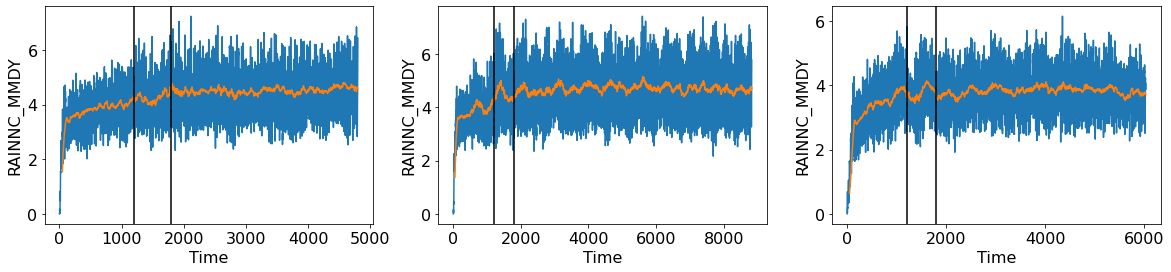

In [7]:
_,axs = plt.subplots(1,3,figsize=(20,4))
for Sim,ax in zip((W10S300,W12S300,W10S296),axs):
    testr = Sim.RAINNC[:-1].mean(['south_north','distance_from_mtn']).load()
    testr.plot(ax=ax)
    testr.rolling(Time=48).mean().plot(ax=ax)
    ax.axvline(1200,color='k')
    ax.axvline(1800,color='k')

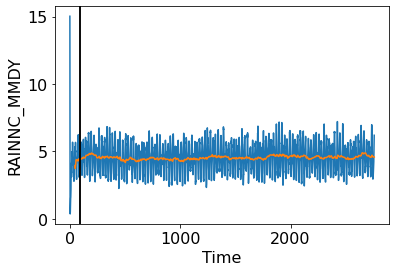

In [43]:
%time testr = W10S300n.RAINNC[:-1].mean(['south_north','distance_from_mtn']).load()
testr.plot()
testr.rolling(Time=48).mean().plot()
plt.axvline(96,color='k')
plt.axvline(96,color='k')

# Precip plots w/ uncertainty

In [ ]:
for Sim in (W10S300,W12S300,W10S296):
    Sim.RAINNC_ALL_SECTION = Sim.RAINNC_ALL.mean(['Time','south_north']).load()
    Sim.RAINNC_ALL_SECTION_STD = Sim.RAINNC_ALL.mean('south_north').coarsen(Time=24).mean().std('Time').load()
    Sim.RAINNC_BASE = Sim.RAINNC_ALL_SECTION.sel(distance_from_mtn=slice(-2000,-5000)).mean()

(-1000.0, 1000.0)

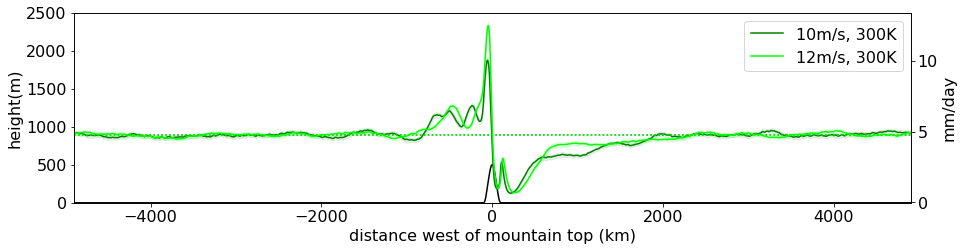

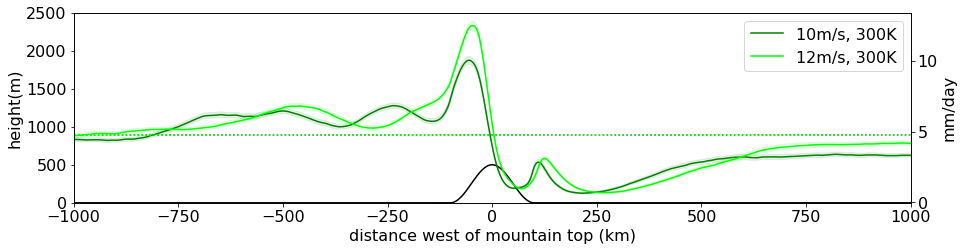

In [55]:
matplotlib.rcParams.update({'font.size':16})
for _ in range(2):
    ax,ax2=plotsection(W10S300.input.HGT[0,0],figsize=(15,3.5))
    
    for Sim in (W10S300,W12S300):
        Sim.RAINNC_ALL_SECTION.plot(ax=ax2,color=Sim.color,label=Sim.label)
        ax2.fill_between(Sim.RAINNC_ALL_SECTION.distance_from_mtn,Sim.RAINNC_ALL_SECTION-2*Sim.RAINNC_ALL_SECTION_STD/np.sqrt(len(Sim.RAINNC_ALL.Time)/24),Sim.RAINNC_ALL_SECTION+2*Sim.RAINNC_ALL_SECTION_STD/np.sqrt(len(Sim.RAINNC_ALL.Time)/24),alpha=0.1,color=Sim.color)
        ax2.axhline(Sim.RAINNC_BASE,color=Sim.color,linestyle=':')
   
    ax2.set_ylabel("mm/day")
    ax2.legend()
    ax.set_xlim(-4900,4900)
    ax.set_ylim(0.,2500.)
ax.set_xlim(-1000,1000)

In [57]:
W10S300.peakprecip_ts = W10S300.RAINNC_ALL[:,:,1652:1656].mean(('south_north','distance_from_mtn')).coarsen(Time=24).mean()
W12S300.peakprecip_ts = W12S300.RAINNC_ALL[:,:,1649:1653].mean(('south_north','distance_from_mtn')).coarsen(Time=24).mean()
print("Peak precip:", end=' '); ratio_CI(W10S300.peakprecip_ts,W12S300.peakprecip_ts,'(m/s)',norm=2)
print("Peak P':    ", end=' '); ratio_CI(W10S300.peakprecip_ts-W10S300.RAINNC_BASE,W12S300.peakprecip_ts-W12S300.RAINNC_BASE,'(m/s)',norm=2)

Peak precip: Change is 12.2 %/(m/s) (95% CI = [9.9 to 14.5])
Peak P':     Change is 22.8 %/(m/s) (95% CI = [18.0 to 27.6])


In [10]:
W10S300.peakprecip_ts = W10S300.RAINNC_ALL[:,:,1652:1656].mean(('south_north','distance_from_mtn'))
W12S300.peakprecip_ts = W12S300.RAINNC_ALL[:,:,1649:1653].mean(('south_north','distance_from_mtn'))
print("Peak precip:", end=' '); ratio_CI(W10S300.peakprecip_ts,W12S300.peakprecip_ts,'(m/s)',norm=2)
print("Peak P':    ", end=' '); ratio_CI(W10S300.peakprecip_ts-W10S300.RAINNC_BASE,W12S300.peakprecip_ts-W12S300.RAINNC_BASE,'(m/s)',norm=2)

Peak precip: Change is 12.2 %/(m/s) (95% CI = [10.1 to 14.3])
Peak P':     Change is 22.8 %/(m/s) (95% CI = [18.5 to 27.1])


(-1000.0, 1000.0)

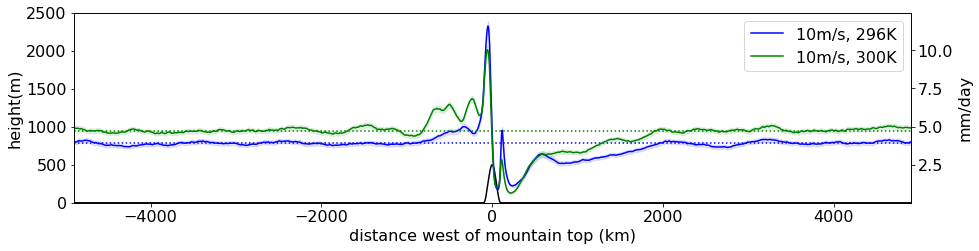

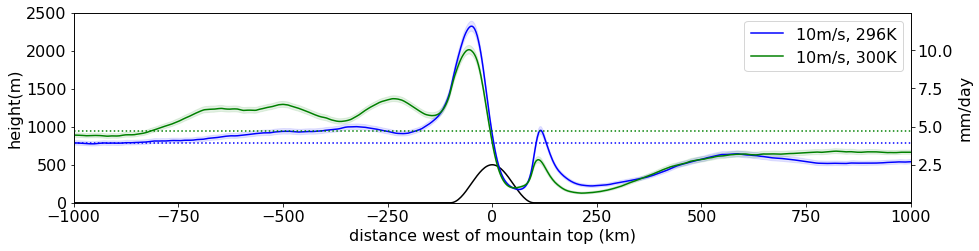

In [34]:
matplotlib.rcParams.update({'font.size':16})
for _ in range(2):
    ax,ax2=plotsection(W10S300.input.HGT[0,0],figsize=(15,3.5))
    
    for Sim in (W10S296,W10S300):
        Sim.RAINNC_ALL_SECTION.plot(ax=ax2,color=Sim.color,label=Sim.label)
        ax2.fill_between(Sim.RAINNC_ALL_SECTION.distance_from_mtn,Sim.RAINNC_ALL_SECTION-2*Sim.RAINNC_ALL_SECTION_STD/np.sqrt(len(Sim.RAINNC_ALL.Time)/24),Sim.RAINNC_ALL_SECTION+2*Sim.RAINNC_ALL_SECTION_STD/np.sqrt(len(Sim.RAINNC_ALL.Time)/24),alpha=0.1,color=Sim.color)
        ax2.axhline(Sim.RAINNC_BASE,color=Sim.color,linestyle=':')
   
    ax2.set_ylabel("mm/day")
    ax2.legend()
    ax.set_xlim(-4900,4900)
    ax.set_ylim(0.,2500.)
ax.set_xlim(-1000,1000)


(-1000.0, 1000.0)

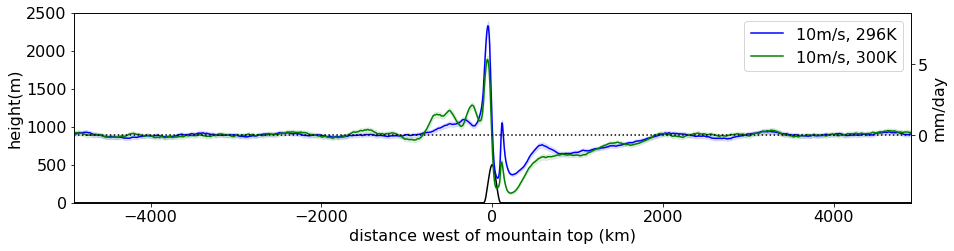

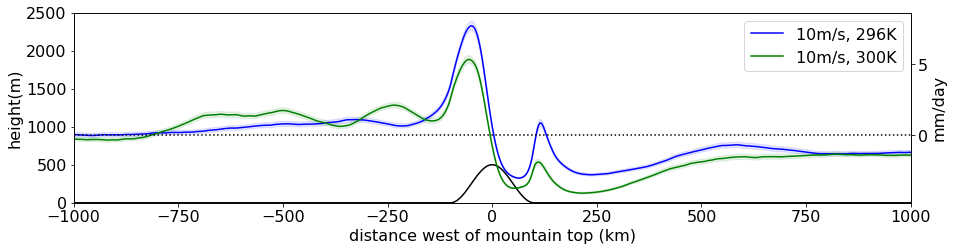

In [17]:
matplotlib.rcParams.update({'font.size':16})
for _ in range(2):
    ax,ax2=plotsection(W10S300.input.HGT[0,0],figsize=(15,3.5))
    for Sim in (W10S296,W10S300):
        prime(Sim.RAINNC_ALL_SECTION).plot(ax=ax2,color=Sim.color,label=Sim.label)
        ax2.fill_between(Sim.RAINNC_ALL_SECTION.distance_from_mtn,prime(Sim.RAINNC_ALL_SECTION)-2*Sim.RAINNC_ALL_SECTION_STD/np.sqrt(len(Sim.RAINNC_ALL.Time)/24),prime(Sim.RAINNC_ALL_SECTION)+2*Sim.RAINNC_ALL_SECTION_STD/np.sqrt(len(Sim.RAINNC_ALL.Time)/24),alpha=0.1,color=Sim.color)
    ax2.axhline(0.,color='k',linestyle=':')
    
    ax2.set_ylabel("mm/day")
    ax2.legend()
    ax.set_ylim(0.,2500.)
    ax.set_xlim(-4900,4900)
ax.set_xlim(-1000,1000)

In [60]:
W10S296.peakprecip_ts = W10S296.RAINNC_ALL[:,:,1650:1654].mean(('south_north','distance_from_mtn')).coarsen(Time=24).mean()
W10S300.peakprecip_ts = W10S300.RAINNC_ALL[:,:,1652:1656].mean(('south_north','distance_from_mtn')).coarsen(Time=24).mean()
print("Peak precip:", end=' '); ratio_CI(W10S296.peakprecip_ts,W10S300.peakprecip_ts,'K',norm=4)
print("Peak P':    ", end=' '); ratio_CI(W10S296.peakprecip_ts-W10S296.RAINNC_BASE,W10S300.peakprecip_ts-W10S300.RAINNC_BASE,'K',norm=4)

Peak precip: Change is -3.3 %/K (95% CI = [-4.2 to -2.4])
Peak P':     Change is -7.7 %/K (95% CI = [-8.9 to -6.5])


In [11]:
W10S296.peakprecip_ts = W10S296.RAINNC_ALL[:,:,1650:1654].mean(('south_north','distance_from_mtn'))
W10S300.peakprecip_ts = W10S300.RAINNC_ALL[:,:,1652:1656].mean(('south_north','distance_from_mtn'))
print("Peak precip:", end=' '); ratio_CI(W10S296.peakprecip_ts,W10S300.peakprecip_ts,'K',norm=4)
print("Peak P':    ", end=' '); ratio_CI(W10S296.peakprecip_ts-W10S296.RAINNC_BASE,W10S300.peakprecip_ts-W10S300.RAINNC_BASE,'K',norm=4)

Peak precip: Change is -3.3 %/K (95% CI = [-4.0 to -2.6])
Peak P':     Change is -7.7 %/K (95% CI = [-8.7 to -6.7])


# More precise uncertainty estimates - blocked bootstrapping

In [90]:
W10S300.peakprecip_ts = W10S300.RAINNC_ALL[:,:,1652:1656].mean(('south_north','distance_from_mtn'))
W10S300.peakprecip_sd = W10S300.peakprecip_ts.std('Time').load()
W10S300.peakprecip_mean = W10S300.peakprecip_ts.mean('Time').load()

In [91]:
print("Hourly: %.3f ± %.3f mm/day"%(W10S300.peakprecip_mean,2*W10S300.peakprecip_sd/np.sqrt(len(W10S300.peakprecip_ts))))

Hourly: 10.014 ± 0.253 mm/day


In [92]:
print("Daily: %.3f ± %.3f mm/day"%(W10S300.peakprecip_mean,2*W10S300.peakprecip_ts.coarsen(Time=24).mean().std('Time')/np.sqrt(len(W10S300.peakprecip_ts)/24)))

Daily: 10.014 ± 0.278 mm/day


In [102]:
ts_sub = W10S300.peakprecip_ts[:3600*5]
n=25
%time autocorrs = [np.corrcoef(ts_sub[:-n],ts_sub[i:len(ts_sub)-n+i])[0,1] for i in range(0,n)]

CPU times: user 9.23 s, sys: 749 ms, total: 9.98 s
Wall time: 12.5 s


In [94]:
ts_sub = W10S300.peakprecip_ts[:3600]
n2=72*2
%time autocorrs2 = [np.corrcoef(ts_sub[:-n2],ts_sub[i:len(ts_sub)-n2+i])[0,1] for i in range(0,n2,2)]

CPU times: user 7 s, sys: 840 ms, total: 7.84 s
Wall time: 15.8 s


Text(0, 0.5, 'autocorrelation')

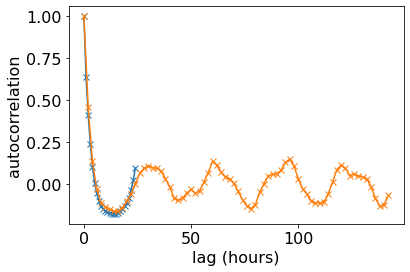

In [103]:
plt.plot(range(n),autocorrs,'-x')
plt.plot(range(0,n2,2),autocorrs2,'-x')
plt.xlabel('lag (hours)')
plt.ylabel('autocorrelation')

In [104]:
ts_sub = W10S300.peakprecip_ts.coarsen(Time=24).mean().load()
ndays=10
%time autocorrsdaily = [np.corrcoef(ts_sub[:-ndays],ts_sub[i:len(ts_sub)-ndays+i])[0,1] for i in range(0,ndays)]

CPU times: user 8.42 ms, sys: 350 µs, total: 8.77 ms
Wall time: 7.55 ms


Text(0, 0.5, 'autocorrelation')

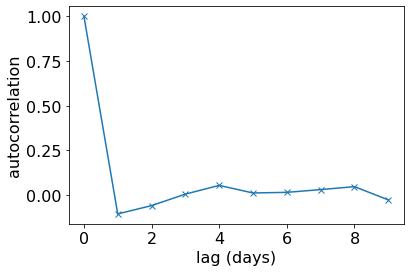

In [105]:
plt.plot(range(ndays),autocorrsdaily,'-x')
plt.xlabel('lag (days)')
plt.ylabel('autocorrelation')

In [149]:
ts_sub = np.array(W10S300.peakprecip_ts)

In [167]:
nbootstrap = 10000
samplesizes = 48
nsamples_per_bootstrap = len(ts_sub)//samplesizes

nsamples = nbootstrap*nsamples_per_bootstrap

idxs = np.random.choice(len(ts_sub)-samplesizes,nsamples,replace=True)
idx_blocks = np.broadcast_to(idxs,(samplesizes,nsamples)).T + np.arange(samplesizes)
blocks = ts_sub[idx_blocks].reshape(nbootstrap,nsamples_per_bootstrap*samplesizes)
block_means = blocks.mean(axis=1)

In [176]:
nbootstrap = 10000
nsamples_per_bootstrap = len(ts_sub)

nsamples = nbootstrap*nsamples_per_bootstrap

draws = np.random.choice(ts_sub,nsamples,replace=True).reshape(nbootstrap,nsamples_per_bootstrap)
bootstrap_means = draws.mean(axis=1)

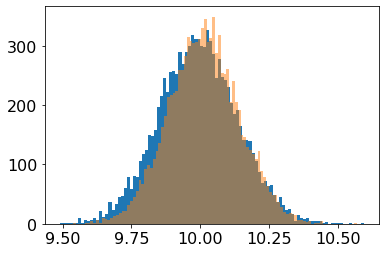

In [181]:
plt.hist(block_means,bins=100);None
plt.hist(bootstrap_means,bins=100,alpha=0.5);None

In [175]:
halfwidth_95th = (np.quantile(block_means,0.975)-np.quantile(block_means,0.025))/2
halfwidth_95th

0.2820355772972105

In [178]:
halfwidth_95th = (np.quantile(bootstrap_means,0.975)-np.quantile(bootstrap_means,0.025))/2
halfwidth_95th

0.24988322257995588

## Farther upstream

In [ ]:
1710,1750

In [35]:
testts = W10S300.RAINNC_ALL[:,:,1710].mean(('south_north')).coarsen(Time=24).mean()
testts_std = testts.std('Time').load()

testts2 = W10S300.RAINNC_ALL[:,:,1750].mean(('south_north')).coarsen(Time=24).mean()
testts2_std = testts2.std('Time').load()

In [36]:
print("Daily: %.3f ± %.3f mm/day"%(testts.mean("Time"),2*testts_std/np.sqrt(len(testts))))
print("Daily: %.3f ± %.3f mm/day"%(testts2.mean("Time"),2*testts2_std/np.sqrt(len(testts2))))

Daily: 6.799 ± 0.192 mm/day
Daily: 5.405 ± 0.175 mm/day


In [37]:
ndays=10
%time autocorrsdaily = [np.corrcoef(testts[:-ndays],testts[i:len(testts)-ndays+i])[0,1] for i in range(0,ndays)]

CPU times: user 4.86 s, sys: 148 ms, total: 5.01 s
Wall time: 6.08 s


Text(0, 0.5, 'autocorrelation')

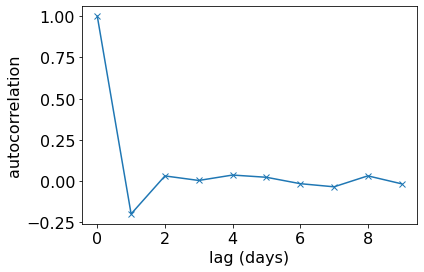

In [38]:
plt.plot(range(ndays),autocorrsdaily,'-x')
plt.xlabel('lag (days)')
plt.ylabel('autocorrelation')

In [68]:
ts_sub=np.array(testts)
nbootstrap = 10000
samplesizes = 4
nsamples_per_bootstrap = len(ts_sub)//samplesizes

nsamples = nbootstrap*nsamples_per_bootstrap

idxs = np.random.choice(len(ts_sub)-samplesizes,nsamples,replace=True)
idx_blocks = np.broadcast_to(idxs,(samplesizes,nsamples)).T + np.arange(samplesizes)
blocks = ts_sub[idx_blocks].reshape(nbootstrap,nsamples_per_bootstrap*samplesizes)
block_means = blocks.mean(axis=1)

In [69]:
ts_sub=np.array(W10S300.RAINNC_ALL[:,:,1710].mean(('south_north')))
nbootstrap = 10000
samplesizes = 48*2
nsamples_per_bootstrap = len(ts_sub)//samplesizes

nsamples = nbootstrap*nsamples_per_bootstrap

idxs = np.random.choice(len(ts_sub)-samplesizes,nsamples,replace=True)
idx_blocks = np.broadcast_to(idxs,(samplesizes,nsamples)).T + np.arange(samplesizes)
blocks = ts_sub[idx_blocks].reshape(nbootstrap,nsamples_per_bootstrap*samplesizes)
block_means2 = blocks.mean(axis=1)

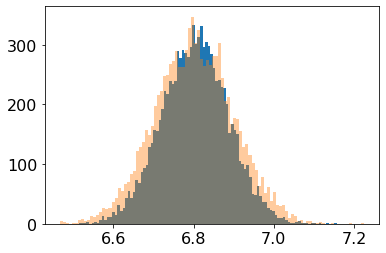

In [70]:
plt.hist(block_means,bins=100);None
plt.hist(block_means2,bins=100,alpha=0.4);None


In [71]:
halfwidth_95th = (np.quantile(block_means,0.975)-np.quantile(block_means,0.025))/2
halfwidth_95th

0.16330581307411185

In [72]:
halfwidth_95th = (np.quantile(block_means2,0.975)-np.quantile(block_means2,0.025))/2
halfwidth_95th

0.1923257172107702

# Precip pdfs

In [17]:
def get_density_dask_fast(a,bins):
    return dask.array.histogram(a,bins,density=True)[0].compute()
def calc_cdf_fast(pr,pctile_levels):
    pctiles = dask.array.percentile(pr.reshape(-1),pctile_levels).compute()
    segsums = dask.array.histogram(pr,np.concatenate((pctiles,[1e7])),weights=pr)[0].compute()
    icdf = (np.cumsum(segsums[::-1])/pr.sum().compute())[::-1]
    return icdf

In [18]:
bins = 10**np.linspace(-2,4,101)
bin_centers = (bins[1:]+bins[:-1])/2
for Sim in (W10S300,W10S296):#(W10S300,W12S300,W10S296):
    Sim.RAINNC_PDF_RCE = get_density_dask_fast(Sim.RAINNC_ALL.sel(distance_from_mtn=slice(-2000,-5000)).data,bins)
    Sim.RAINNC_PDF_UPS = get_density_dask_fast(Sim.RAINNC_ALL.sel(distance_from_mtn=slice(-200,-500)).data,bins)
    Sim.RAINNC_PDF_MTN = get_density_dask_fast(Sim.RAINNC_ALL.sel(distance_from_mtn=slice(0,-100)).data,bins)

In [10]:
pctile_levels = 100*(1-10**(-np.linspace(0.01,5,41)))
for Sim in (W10S300,W12S300,W10S296):
    Sim.RAINNC_ICDF_RCE = calc_cdf_fast(Sim.RAINNC_ALL.sel(distance_from_mtn=slice(-2000,-5000)).data,pctile_levels)
    Sim.RAINNC_ICDF_UPS = calc_cdf_fast(Sim.RAINNC_ALL.sel(distance_from_mtn=slice(-200,-500))  .data,pctile_levels)
    Sim.RAINNC_ICDF_MTN = calc_cdf_fast(Sim.RAINNC_ALL.sel(distance_from_mtn=slice(0,-100))     .data,pctile_levels)

In [16]:
pctile_levels_daily = 100*(1-10**(-np.linspace(0.01,3,41)))
for Sim in (W10S300,W12S300,W10S296):
    Sim.RAINNC_ICDF_DAILY_RCE = calc_cdf_fast(Sim.RAINNC_ALL.sel(distance_from_mtn=slice(-2000,-5000)).coarsen(Time=24).mean().data,pctile_levels_daily)
    Sim.RAINNC_ICDF_DAILY_UPS = calc_cdf_fast(Sim.RAINNC_ALL.sel(distance_from_mtn=slice(-200,-500))  .coarsen(Time=24).mean().data,pctile_levels_daily)
    Sim.RAINNC_ICDF_DAILY_MTN = calc_cdf_fast(Sim.RAINNC_ALL.sel(distance_from_mtn=slice(0,-100))     .coarsen(Time=24).mean().data,pctile_levels_daily)

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [18]:
for Sim in (W10S300,W12S300,W10S296):
    Sim.RAINNC_PCTILES_RCE = dask.array.percentile(Sim.RAINNC_ALL.sel(distance_from_mtn=slice(-2000,-5000)).data.reshape(-1),pctile_levels).compute()
    Sim.RAINNC_PCTILES_UPS = dask.array.percentile(Sim.RAINNC_ALL.sel(distance_from_mtn=slice(-200,-500))  .data.reshape(-1),pctile_levels).compute()
    Sim.RAINNC_PCTILES_MTN = dask.array.percentile(Sim.RAINNC_ALL.sel(distance_from_mtn=slice(0,-100))     .data.reshape(-1),pctile_levels).compute()

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [27]:
for Sim in (W10S300,W12S300,W10S296):
    Sim.RAINNC_PCTILES_DAILY_RCE = dask.array.percentile(Sim.RAINNC_ALL.sel(distance_from_mtn=slice(-2000,-5000)).coarsen(Time=24).mean().data.reshape(-1),pctile_levels_daily).compute()
    Sim.RAINNC_PCTILES_DAILY_UPS = dask.array.percentile(Sim.RAINNC_ALL.sel(distance_from_mtn=slice(-200,-500))  .coarsen(Time=24).mean().data.reshape(-1),pctile_levels_daily).compute()
    Sim.RAINNC_PCTILES_DAILY_MTN = dask.array.percentile(Sim.RAINNC_ALL.sel(distance_from_mtn=slice(0,-100))     .coarsen(Time=24).mean().data.reshape(-1),pctile_levels_daily).compute()

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


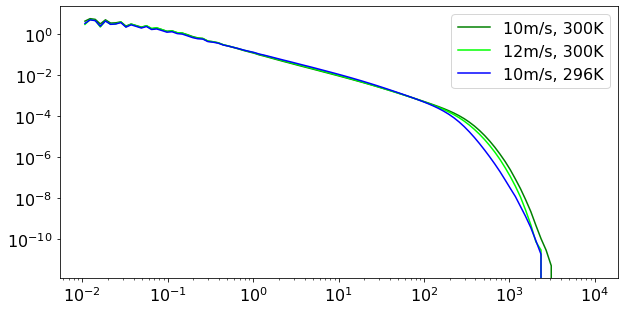

In [104]:
_,ax=plt.subplots(1,1,figsize=(10,5))
for Sim in (W10S300,W12S300,W10S296):
    ax.loglog(bin_centers,Sim.RAINNC_PDF_RCE,color=Sim.color,label=Sim.label)
#    ax.loglog(bin_centers,Sim.RAINNC_PDF_MTN,color=Sim.color,linestyle='--',label=Sim.label)
ax.legend()

**extremely high rainfall is more likely in the RCE region than over the mountain:**

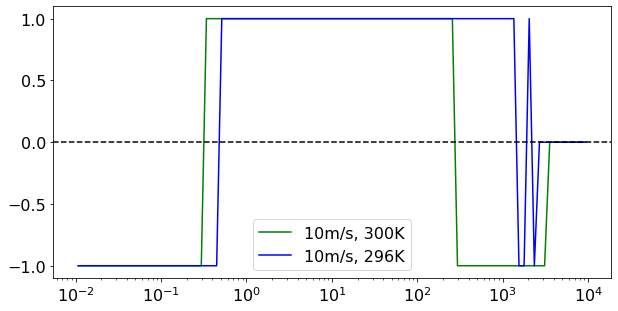

In [21]:
_,ax=plt.subplots(1,1,figsize=(10,5))
for Sim in (W10S300,W10S296):
    ax.plot(bin_centers,np.sign(Sim.RAINNC_PDF_MTN-Sim.RAINNC_PDF_RCE),color=Sim.color,label=Sim.label)
    #ax.loglog(bin_centers,Sim.RAINNC_PDF_MTN,color=Sim.color,linestyle='--',label=Sim.label)
ax.legend()
ax.axhline(0.,linestyle='--',color='k')
ax.set_xscale('log')

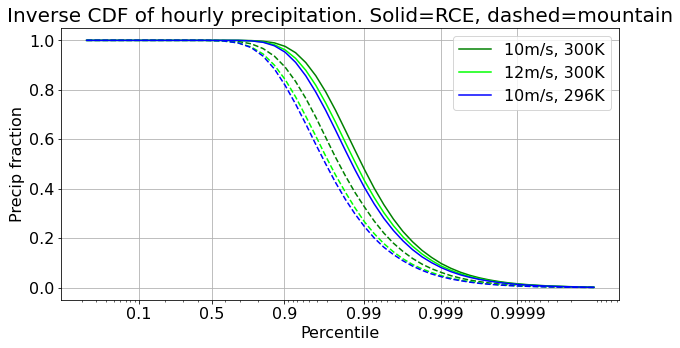

In [110]:
_,ax=plt.subplots(1,1,figsize=(10,5))
for Sim in (W10S300,W12S300,W10S296):
    ax.plot(pctile_levels/100,Sim.RAINNC_ICDF_RCE,color=Sim.color,label=Sim.label)
    ax.plot(pctile_levels/100,Sim.RAINNC_ICDF_MTN,color=Sim.color,linestyle='--' )

ax.legend()
ax.set_xscale('logit')
ax.set_xticks([0.1,0.5,0.9,0.99,0.999,0.9999])
ax.set_xticklabels([0.1,0.5,0.9,0.99,0.999,0.9999])  
ax.set_title("Inverse CDF of hourly precipitation. Solid=RCE, dashed=mountain",fontsize=20)
ax.set_xlabel("Percentile")
ax.set_ylabel("Precip fraction")
ax.grid()

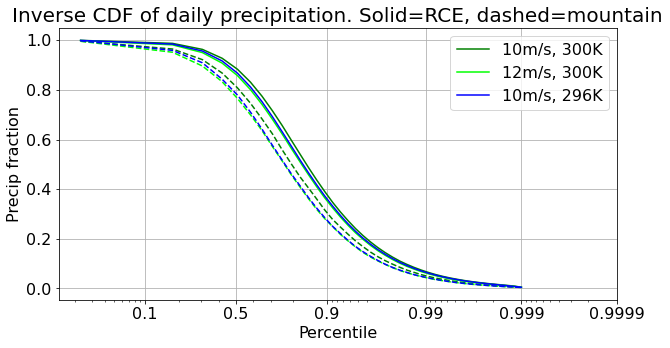

In [17]:
_,ax=plt.subplots(1,1,figsize=(10,5))
for Sim in (W10S300,W12S300,W10S296):
    ax.plot(pctile_levels_daily/100,Sim.RAINNC_ICDF_DAILY_RCE,color=Sim.color,label=Sim.label)
    ax.plot(pctile_levels_daily/100,Sim.RAINNC_ICDF_DAILY_MTN,color=Sim.color,linestyle='--' )

ax.legend()
ax.set_xscale('logit')
ax.set_xticks([0.1,0.5,0.9,0.99,0.999,0.9999])
ax.set_xticklabels([0.1,0.5,0.9,0.99,0.999,0.9999])  
ax.set_title("Inverse CDF of daily precipitation. Solid=RCE, dashed=mountain",fontsize=20)
ax.set_xlabel("Percentile")
ax.set_ylabel("Precip fraction")
ax.grid()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


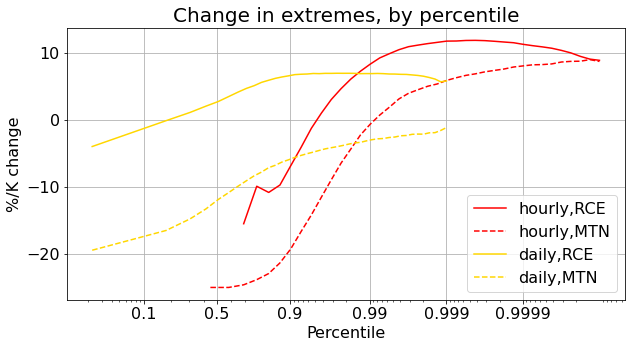

In [30]:
_,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(pctile_levels/100,(W10S300.RAINNC_PCTILES_RCE/W10S296.RAINNC_PCTILES_RCE - 1)/4*100,color='r',label='hourly,RCE')
ax.plot(pctile_levels/100,(W10S300.RAINNC_PCTILES_UPS/W10S296.RAINNC_PCTILES_MTN - 1)/4*100,color='r',linestyle='--',label='hourly,MTN')
ax.plot(pctile_levels_daily/100,(W10S300.RAINNC_PCTILES_DAILY_RCE/W10S296.RAINNC_PCTILES_DAILY_RCE - 1)/4*100,color='gold',label='daily,RCE')
ax.plot(pctile_levels_daily/100,(W10S300.RAINNC_PCTILES_DAILY_UPS/W10S296.RAINNC_PCTILES_DAILY_MTN - 1)/4*100,color='gold',linestyle='--',label='daily,MTN')

ax.legend()
ax.set_xscale('logit')
ax.set_xticks([0.1,0.5,0.9,0.99,0.999,0.9999])
ax.set_xticklabels([0.1,0.5,0.9,0.99,0.999,0.9999])  
ax.set_title("Change in extremes, by percentile",fontsize=20)
ax.set_xlabel("Percentile")
ax.set_ylabel("%/K change")
ax.grid()

# TL,qL plots

In [10]:
from tools.generalTools import qsat

In [11]:
for Sim in (W10S300,W12S300,W10S296):
    Sim.TL_MEAN = Sim.T_PL_MEAN.sel(pressure=slice(900,700)).mean('pressure')
    Sim.QL_MEAN = Sim.Q_PL_MEAN.sel(pressure=slice(900,700)).mean('pressure')
    Sim.QSATL_MEAN = qsat(Sim.T_PL_MEAN,Sim.T_PL_MEAN.pressure).sel(pressure=slice(900,700)).mean('pressure')
    Sim.EL = Sim.TL_MEAN + 2.5e3*Sim.QL_MEAN
    Sim.ELSTAR = Sim.TL_MEAN + 2.5e3*Sim.QSATL_MEAN
    Sim.EB = Sim.T_PL_MEAN.sel(pressure=slice(1000,900)).mean('pressure') + 2.5e3*Sim.Q_PL_MEAN.sel(pressure=slice(1000,900)).mean('pressure')

increase in max, WRF: T = 7.7%/K,  q = 6.9%/K


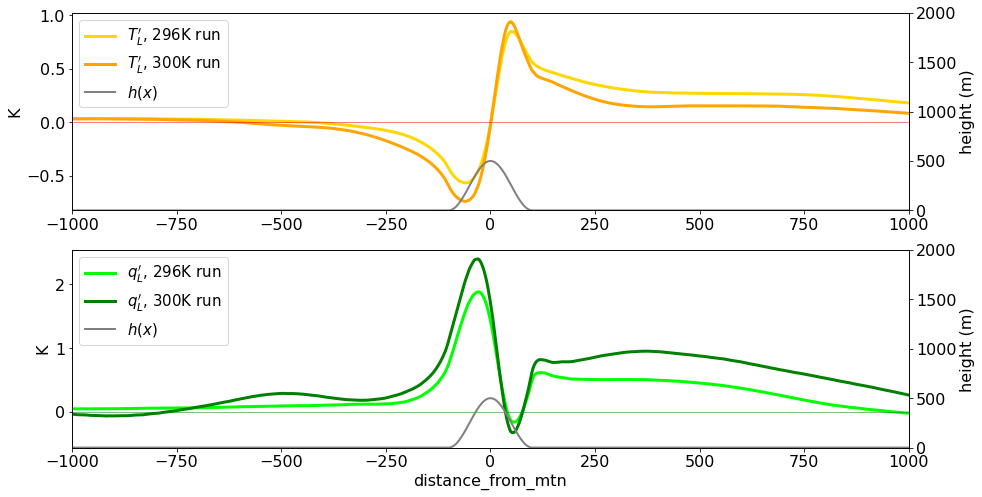

In [8]:
fig,(ax,ax2) = plt.subplots(2,1,figsize=(15,8))
axm=ax.twinx()
ax2m=ax2.twinx()

# Panel a : temperature deviations
prime(W10S296.TL_MEAN).plot(ax=ax,color='gold'  ,linewidth=3,label=r"$T_L'$, 296K run")
prime(W10S300.TL_MEAN).plot(ax=ax,color='orange',linewidth=3,label=r"$T_L'$, 300K run")
ax.axhline(0.,linestyle='-',linewidth='0.5',color='red')

# Panel b : moisture deviations
prime(2.5e3*W10S296.QL_MEAN).plot(ax=ax2,color='lime' ,linewidth=3,label=r"$q_L'$, 296K run")
prime(2.5e3*W10S300.QL_MEAN).plot(ax=ax2,color='green',linewidth=3,label=r"$q_L'$, 300K run")
ax2.axhline(0.,linestyle='-',linewidth='0.5',color='green')


for a,am in (ax,axm),(ax2,ax2m):
    a.set_xlim(-1000,1000)
    a.set_ylabel("K")
    a.legend(fontsize=20)
    
    change_coords_sfc(W10S300.input.HGT[0,0]).plot(ax=am,label=r"$h(x)$",color='gray',linewidth=2)
    am.set_ylabel('height (m)')
    am.set_ylim(0,2000)
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2,fontsize=15,loc=2)

ax.set_xlabel('')
print("increase in max, WRF: T = %.1f%%/K,  q = %.1f%%/K"%(100*(prime(W10S300.TL_MEAN).min()/prime(W10S296.TL_MEAN).min()-1)/4,100*(prime(W10S300.QL_MEAN).max()/prime(W10S296.QL_MEAN).max()-1)/4))


## convective time scales

In [80]:
p1 = 1000
p2 = 900
p3 = 700

dp=800
dpb = p1-p2
dpl = p2-p3
wB = dpb/dpl*np.log(1+dpl/dpb)
wL = 1-wB
kappa = 0.286
piB = 1000/(kappa+1)/(dpb) * ((p1/1000)**(kappa+1)-(p2/1000)**(kappa+1))
piL = 1000/(kappa+1)/(dpl) * ((p2/1000)**(kappa+1)-(p3/1000)**(kappa+1))



TL = upstreammean(W10S300.TL_MEAN)
qL = 2.5e3*upstreammean(W10S300.QL_MEAN)
qLstar = 2.5e3*upstreammean(W10S300.QSATL_MEAN)
eLstar = upstreammean(W10S300.ELSTAR)
eL = upstreammean(W10S300.EL)
eB = upstreammean(W10S300.EB)

#TL = upstreammean(W10S296.TL_MEAN)
#qL = 2.5e3*upstreammean(W10S296.QL_MEAN)
#qLstar = 2.5e3*upstreammean(W10S296.QSATL_MEAN)
#eLstar = upstreammean(W10S296.ELSTAR)
#eL = upstreammean(W10S296.EL)
#eB = upstreammean(W10S296.EB)

print("TL = %.2f K, qL = %.2f K, qL* = %.2f K, eB = %.2f K"%(TL,qL,qLstar,eB))

TL = 289.15 K, qL = 19.90 K, qL* = 35.59 K, eB = 333.75 K


In [50]:
wB = 0.52
wL = 1-wB
piB = 0.97
piL = 0.88

TL     = 280.1
qLstar = 23.4
eLstar = 300.9
eL     = 300.16
eB     = 332.88


In [89]:
g=9.81;Lv=2.5e6;Rv=461.;cp=1004.

dBLdeB = g*piL/eLstar * wB/piB
dBLdqL = g/eLstar * wL
dBLdTL = -g/eLstar*piL * ( ( wB*eB/(piB*eLstar) + wL*eL/(piL*eLstar) )*(1+Lv*qLstar/(Rv*TL**2)) - wL/piL )

taub =  cp/Lv*(100*dp/g)/20.6/dBLdeB
tauq =  cp/Lv*(100*dp/g)/20.6/dBLdqL
tauT = -cp/Lv*(100*dp/g)/20.6/dBLdTL

print("taub = %.2f hr, tauq = %.2f hr, tauT = %.2f hr"%(taub,tauq,tauT))

taub = 10.07 hr, tauq = 11.68 hr, tauT = 1.92 hr


# subsaturation?

In [10]:
from tools.generalTools import qsat

In [13]:
for Sim in (W10S300,W12S300,W10S296):
    Sim.QSAT_MEAN = qsat(Sim.T_PL_MEAN,Sim.T_PL_MEAN.pressure)
    Sim.SUBSAT_MEAN = Sim.QSAT_MEAN  - Sim.Q_PL_MEAN 
    Sim.SUBSATL_MEAN = Sim.SUBSAT_MEAN.sel(pressure=slice(900,700)).mean('pressure')

In [ ]:
ax,ax2=plotsection(W10S300.input.HGT[0,0],figsize=(15,3.5))

(-1000.0, 1000.0)

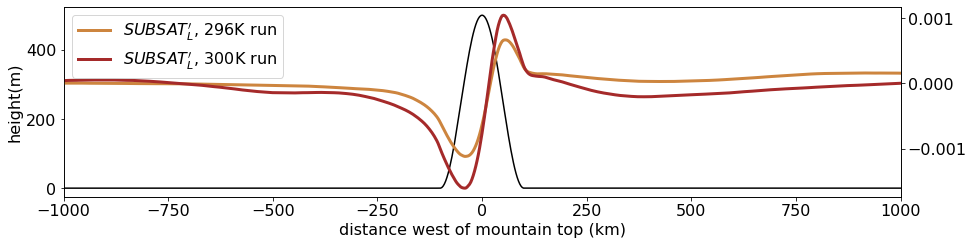

In [18]:
ax,ax2=plotsection(W10S300.input.HGT[0,0],figsize=(15,3.5))

# Panel a : temperature deviations
prime(W10S296.SUBSATL_MEAN).plot(ax=ax2,color='peru'  ,linewidth=3,label=r"$SUBSAT_L'$, 296K run")
prime(W10S300.SUBSATL_MEAN).plot(ax=ax2,color='brown',linewidth=3,label=r"$SUBSAT_L'$, 300K run")
ax2.legend()
ax.set_xlim(-1000,1000)

(-163.45000000000002, 3432.45, -25.0, 525.0)

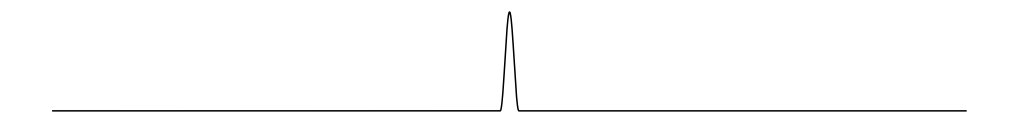

In [66]:
plt.figure(figsize=(18,2))
W10S300.input.HGT[0,0].plot(color='k')
plt.axis('off')

In [68]:
W10S300.input.PB[0,-1,0,0]

<xarray.DataArray 'PB' ()>
array(2015.5566, dtype=float32)
Coordinates:
    XLAT     float32 ...
    XLONG    float32 ...
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  BASE STATE PRESSURE
    units:        Pa
    stagger:      
    coordinates:  XLONG XLAT XTIME

# T,q,w sections

In [7]:
from tools.generalTools import qsat

In [8]:
for Sim in W10S300,W10S296:
    Sim.T_PL_MEAN = xr.open_dataarray(Sim.path+'wrf.T_PL.ALLMEAN.nc')
    Sim.Q_PL_MEAN = xr.open_dataarray(Sim.path+'wrf.Q_PL.ALLMEAN.nc')
    Sim.W_PL_MEAN = xr.open_dataarray(Sim.path+'wrf.W_PL.ALLMEAN.nc')
    Sim.QSAT_PL_MEAN = qsat(Sim.T_PL_MEAN,Sim.T_PL_MEAN.pressure)
    Sim.SUBSAT_PL_MEAN = Sim.QSAT_PL_MEAN - Sim.Q_PL_MEAN
    Sim.RH_PL_MEAN = Sim.Q_PL_MEAN/Sim.QSAT_PL_MEAN


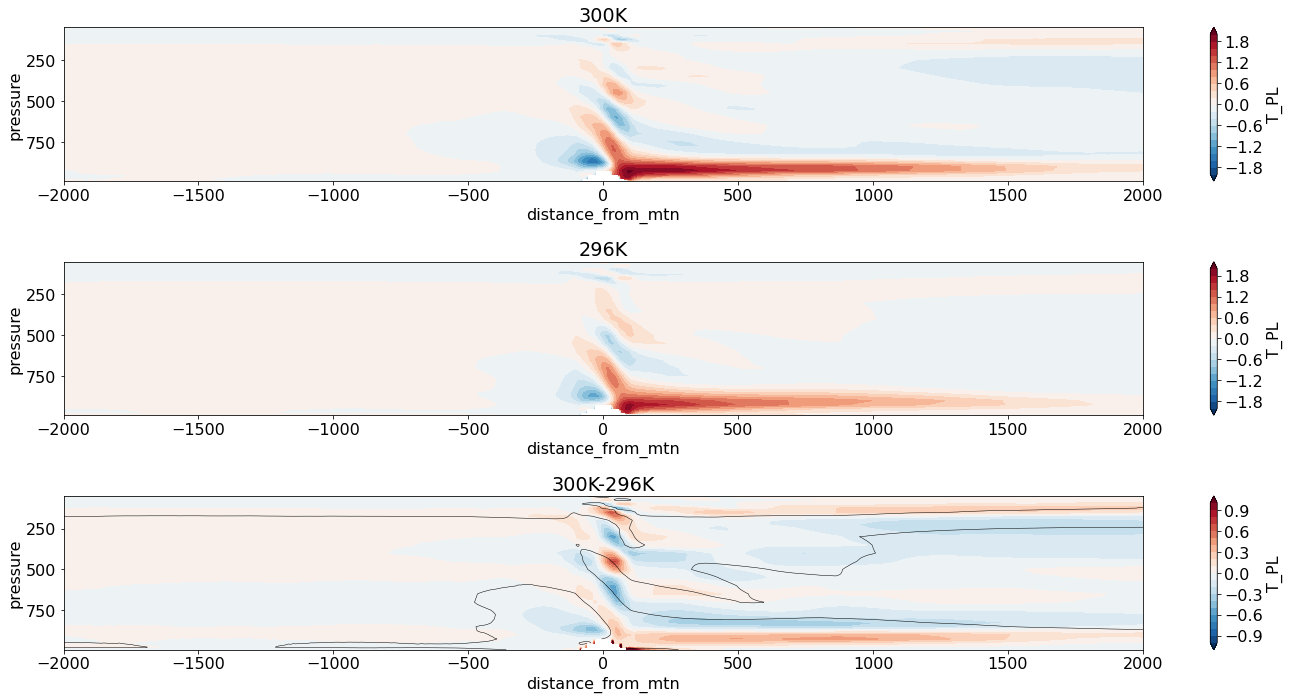

In [20]:
fig,axs = plt.subplots(3,1,figsize=(20,10))
levs1 = np.linspace(-2,2,21)
levs2 = np.linspace(-1,1,21)
prime(W10S300.T_PL_MEAN).plot.contourf(ax=axs[0],yincrease=False,levels=levs1,extend='both')
prime(W10S296.T_PL_MEAN).plot.contourf(ax=axs[1],yincrease=False,levels=levs1,extend='both')
(prime(W10S300.T_PL_MEAN)-prime(W10S296.T_PL_MEAN)).plot.contourf(ax=axs[2],yincrease=False,levels=levs2,extend='both')
prime(W10S296.T_PL_MEAN).plot.contour(ax=axs[2],yincrease=False,levels=[0.],colors='k',linewidths=[0.5])
axs[0].set_title('300K')
axs[1].set_title('296K')
axs[2].set_title('300K-296K')
for ax in axs:
    ax.set_xlim(-2000,2000)
fig.tight_layout()


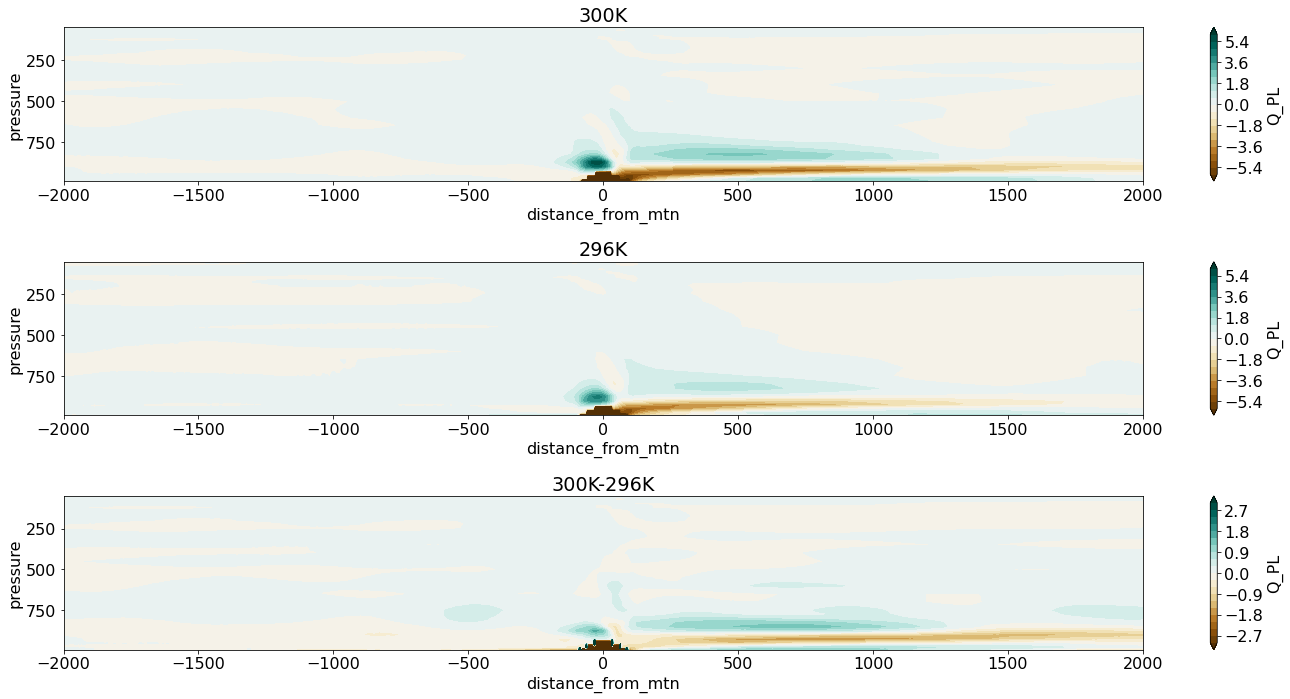

In [22]:
fig,axs = plt.subplots(3,1,figsize=(20,10))
levs1 = np.linspace(-6,6,21)
levs2 = np.linspace(-3,3,21)
prime(2.5e3*W10S300.Q_PL_MEAN).plot.contourf(ax=axs[0],yincrease=False,cmap=plt.cm.BrBG,levels=levs1,extend='both')
prime(2.5e3*W10S296.Q_PL_MEAN).plot.contourf(ax=axs[1],yincrease=False,cmap=plt.cm.BrBG,levels=levs1,extend='both')
(prime(2.5e3*W10S300.Q_PL_MEAN)-prime(2.5e3*W10S296.Q_PL_MEAN)).plot.contourf(ax=axs[2],yincrease=False,cmap=plt.cm.BrBG,levels=levs2,extend='both')
#prime(W10S296.T_PL_MEAN).plot.contour(ax=axs[2],yincrease=False,levels=[0.],colors='k',linewidths=[0.5])
axs[0].set_title('300K')
axs[1].set_title('296K')
axs[2].set_title('300K-296K')
for ax in axs:
    ax.set_xlim(-2000,2000)
fig.tight_layout()


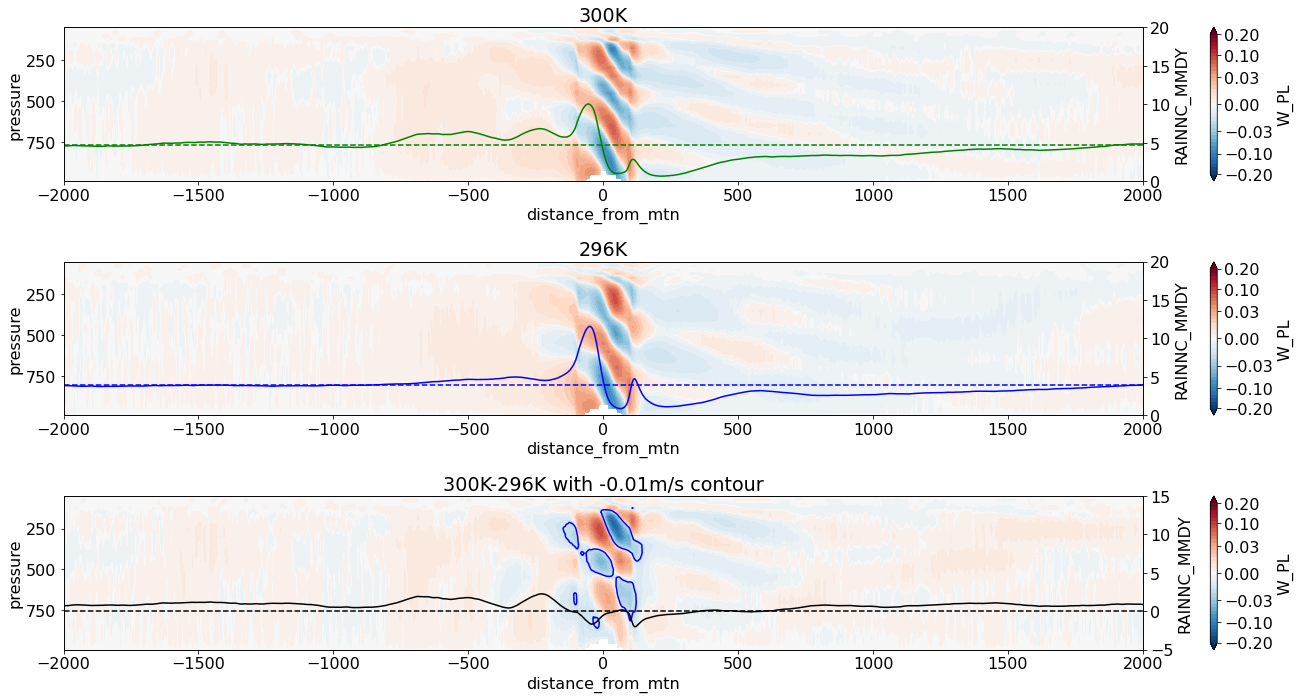

In [14]:
fig,axs = plt.subplots(3,1,figsize=(20,10))
amp=0.03
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

levs1=levs2=levs(0.2,2)
wticks=[-.2,-.1,-.03,0.,.03,.1,.2]


W10S300.W_PL_MEAN.plot.contourf(ax=axs[0],yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})
W10S296.W_PL_MEAN.plot.contourf(ax=axs[1],yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})
(W10S300.W_PL_MEAN-W10S296.W_PL_MEAN).plot.contourf(ax=axs[2],yincrease=False,levels=levs2,extend='both',cbar_kwargs={'ticks':wticks})
CS=(W10S300.W_PL_MEAN-W10S296.W_PL_MEAN).plot.contour(ax=axs[2],yincrease=False,levels=[-0.01],colors=['b'])

ax0 = axs[0].twinx();ax1 = axs[1].twinx();ax2 = axs[2].twinx()
W10S300.RAINNC_ALL_SECTION.plot(ax=ax0,color=W10S300.color); ax0.axhline(W10S300.RAINNC_BASE,linestyle='--',color = W10S300.color)
W10S296.RAINNC_ALL_SECTION.plot(ax=ax1,color=W10S296.color); ax1.axhline(W10S296.RAINNC_BASE,linestyle='--',color = W10S296.color)
(W10S300.RAINNC_ALL_SECTION-W10S296.RAINNC_ALL_SECTION).plot(ax=ax2,color='k'); ax2.axhline(0.,linestyle='--',color = 'k')


ax0.set_ylim(0,20)
ax1.set_ylim(0,20)
ax2.set_ylim(-5,15)




axs[0].set_title('300K')
axs[1].set_title('296K')
axs[2].set_title('300K-296K with -0.01m/s contour')
for ax in axs:
    ax.set_xlim(-2000,2000)
fig.tight_layout()


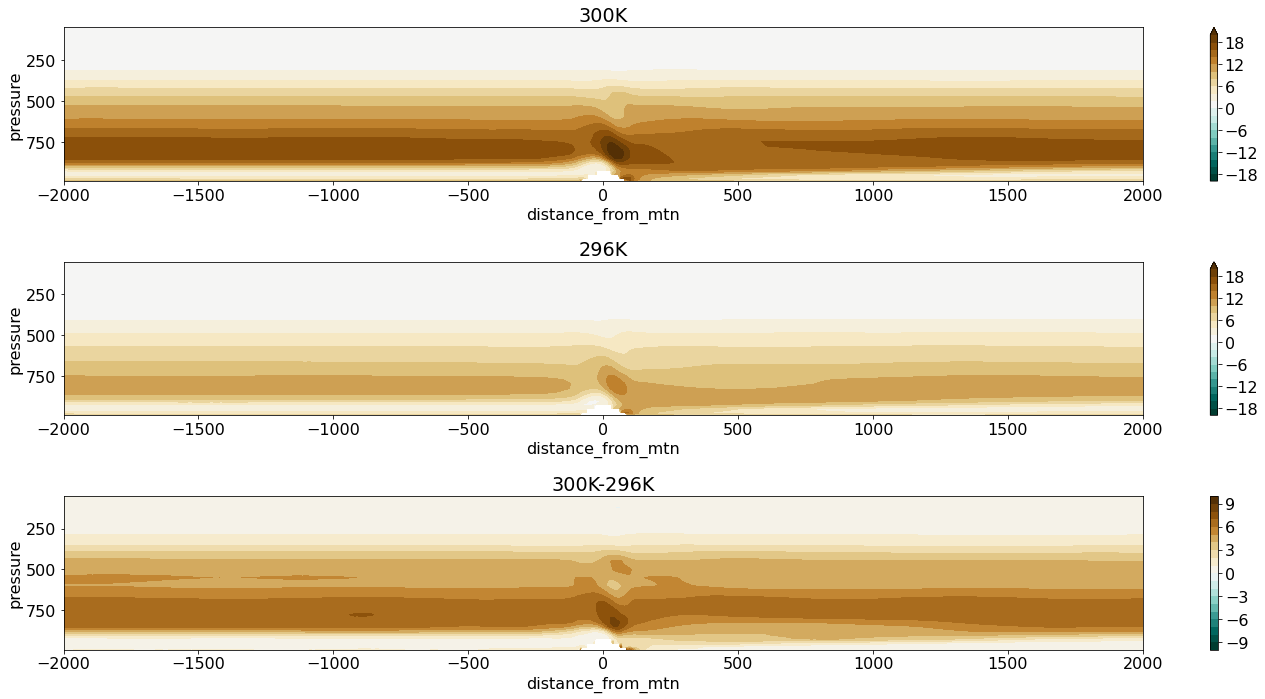

In [12]:
fig,axs = plt.subplots(3,1,figsize=(20,10))
levs1 = np.linspace(-20,20,21)
levs2 = np.linspace(-10,10,21)
(2.5e3*W10S300.SUBSAT_PL_MEAN).plot.contourf(ax=axs[0],yincrease=False,cmap=plt.cm.BrBG_r,levels=levs1)
(2.5e3*W10S296.SUBSAT_PL_MEAN).plot.contourf(ax=axs[1],yincrease=False,cmap=plt.cm.BrBG_r,levels=levs1,extend='max')
((2.5e3*W10S300.SUBSAT_PL_MEAN)-(2.5e3*W10S296.SUBSAT_PL_MEAN)).plot.contourf(ax=axs[2],yincrease=False,cmap=plt.cm.BrBG_r,levels=levs2)
#prime(W10S296.T_PL_MEAN).plot.contour(ax=axs[2],yincrease=False,levels=[0.],colors='k',linewidths=[0.5])
axs[0].set_title('300K')
axs[1].set_title('296K')
axs[2].set_title('300K-296K')
for ax in axs:
    ax.set_xlim(-2000,2000)
fig.tight_layout()


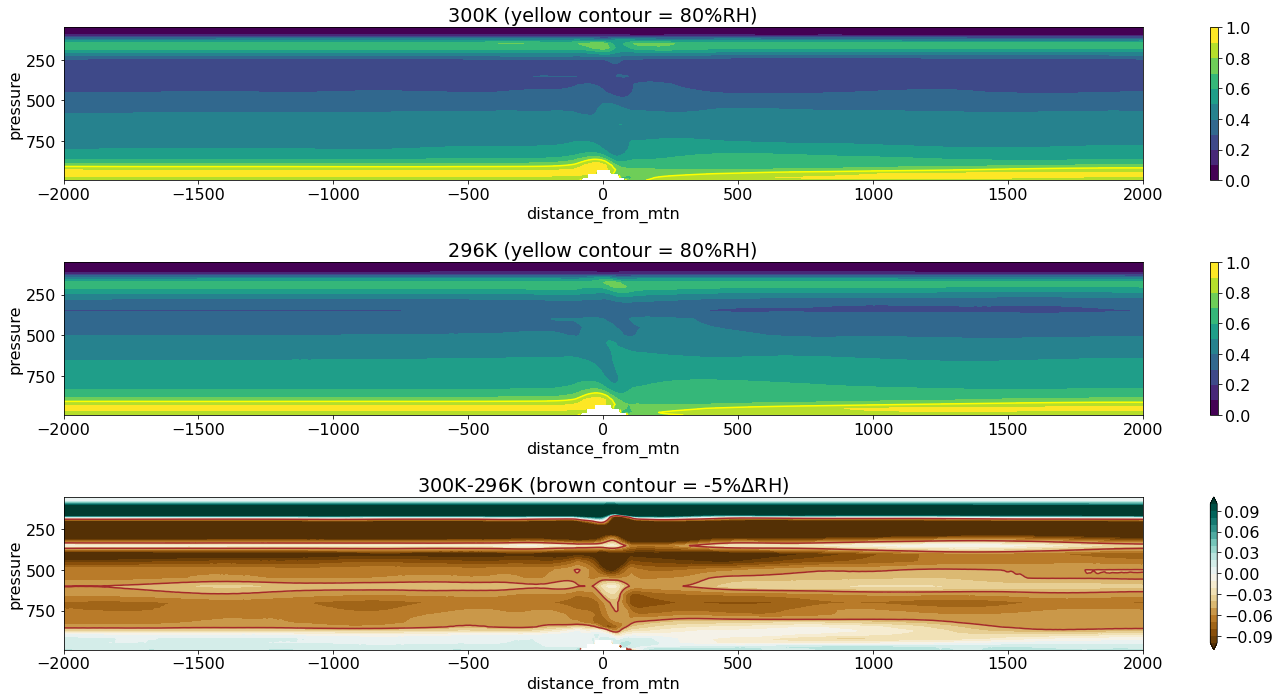

In [15]:
fig,axs = plt.subplots(3,1,figsize=(20,10))
levs1 = np.linspace(0.,1.,11)
levs2 = np.linspace(-0.1,0.1,21)
(W10S300.RH_PL_MEAN).plot.contourf(ax=axs[0],yincrease=False,cmap=plt.cm.viridis,levels=levs1)
(W10S300.RH_PL_MEAN).plot.contour(ax=axs[0],yincrease=False,levels=[0.8],colors=['yellow'])
(W10S296.RH_PL_MEAN).plot.contourf(ax=axs[1],yincrease=False,cmap=plt.cm.viridis,levels=levs1)
(W10S296.RH_PL_MEAN).plot.contour(ax=axs[1],yincrease=False,levels=[0.8],colors=['yellow'])
((W10S300.RH_PL_MEAN)-(W10S296.RH_PL_MEAN)).plot.contourf(ax=axs[2],yincrease=False,cmap=plt.cm.BrBG,levels=levs2)
((W10S300.RH_PL_MEAN)-(W10S296.RH_PL_MEAN)).plot.contour(ax=axs[2],yincrease=False,levels=[-0.05],colors=['brown'])
#prime(W10S296.T_PL_MEAN).plot.contour(ax=axs[2],yincrease=False,levels=[0.],colors='k',linewidths=[0.5])
axs[0].set_title('300K (yellow contour = 80%RH)')
axs[1].set_title('296K (yellow contour = 80%RH)')
axs[2].set_title(r'300K-296K (brown contour = -5%$\Delta$RH)')
for ax in axs:
    ax.set_xlim(-2000,2000)
fig.tight_layout()


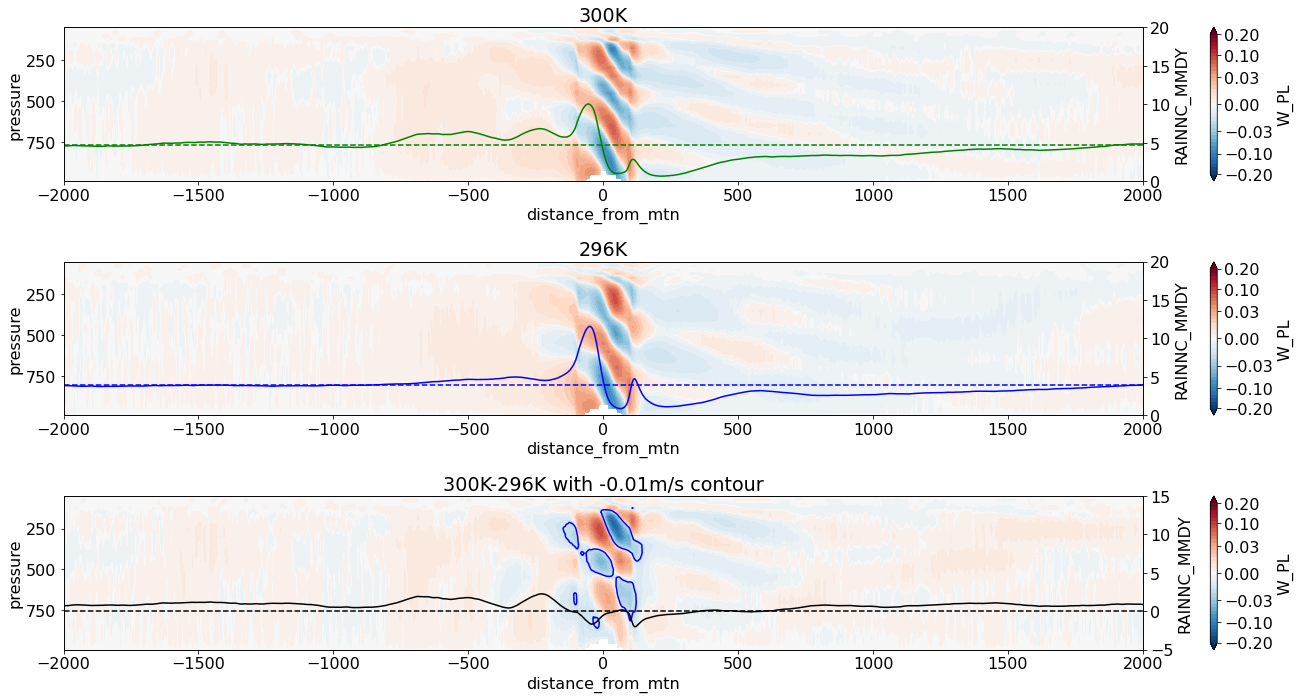

In [14]:
fig,axs = plt.subplots(3,1,figsize=(20,10))


W10S300.SUBSAT_PL_MEAN.plot.contourf(ax=axs[0],yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})
W10S296.W_PL_MEAN.plot.contourf(ax=axs[1],yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})
(W10S300.W_PL_MEAN-W10S296.W_PL_MEAN).plot.contourf(ax=axs[2],yincrease=False,levels=levs2,extend='both',cbar_kwargs={'ticks':wticks})

#ax0 = axs[0].twinx();ax1 = axs[1].twinx();ax2 = axs[2].twinx()
#W10S300.RAINNC_ALL_SECTION.plot(ax=ax0,color=W10S300.color); ax0.axhline(W10S300.RAINNC_BASE,linestyle='--',color = W10S300.color)
#W10S296.RAINNC_ALL_SECTION.plot(ax=ax1,color=W10S296.color); ax1.axhline(W10S296.RAINNC_BASE,linestyle='--',color = W10S296.color)
#(W10S300.RAINNC_ALL_SECTION-W10S296.RAINNC_ALL_SECTION).plot(ax=ax2,color='k'); ax2.axhline(0.,linestyle='--',color = 'k')


ax0.set_ylim(0,20)
ax1.set_ylim(0,20)
ax2.set_ylim(-5,15)




axs[0].set_title('300K')
axs[1].set_title('296K')
axs[2].set_title('300K-296K with -0.01m/s contour')
for ax in axs:
    ax.set_xlim(-2000,2000)
fig.tight_layout()


# Moisture convergence

In [10]:
for Sim in (W10S300,W10S296):
    Sim.RAINNC_ALL_SECTION = Sim.RAINNC_ALL.mean(['Time','south_north']).load()
    Sim.RAINNC_BASE = Sim.RAINNC_ALL_SECTION.sel(distance_from_mtn=slice(-2000,-5000)).mean()
    wrfout = xr.open_zarr(Sim.path+'wrfout.%s.zarr'%Sim.suffix2 )
    lhf = wrfout.isel(Time=slice(200,801)).ACLHF
    Sim.EVAP = change_coords_sfc(86400/2.5e6 * ((lhf[-1]-lhf[0]).mean('south_north')/150/86400))
    #/!\/!\/!\/!\/!\ EVAP ONLY ON FIRST FEW DAYS /!\/!\/!\/!\/!\

## Time mean

In [22]:
def integrate(y,x,x1,x2,y2):
    assert x[1]>=x[0]
    y1 = np.interp(x1,x,y)
    idxs = (x>x1)*(x<x2)*(~np.isnan(y))
    xi = np.concatenate(([x1],x[idxs],[x2]))
    yi = np.concatenate(([y1],y[idxs],[y2]))
    return np.trapz(yi,xi)

In [24]:
for Sim in W10S296,W10S300:
    Sim.Q2_MEAN = xr.open_dataarray(Sim.path+"wrf.Q2_INTERP.ALLMEAN.nc"  )
    Sim.U10_MEAN = xr.open_dataarray(Sim.path+"wrf.U10_INTERP.ALLMEAN.nc")
    Sim.PSFC_MEAN = xr.open_dataarray(Sim.path+'diags/wrf.PSFC.days150-200.nc').mean('south_north')

In [25]:
for Sim in W10S296,W10S300:
    Sim.Q_PL_MEAN = xr.open_dataarray(Sim.path+'wrf.Q_PL.ALLMEAN.nc')
    #Sim.Q_PL_MEAN = Sim.Q_PL_MEAN.where(Sim.PSFC_MEAN/100-7>Sim.Q_PL_MEAN.pressure)
    Sim.U_PL_MEAN = xr.open_dataarray(Sim.path+'wrf.U_PL.ALLMEAN.nc')

(-2000.0, 2000.0)

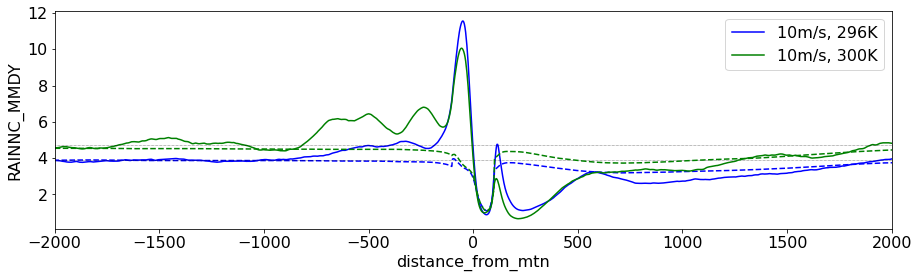

In [27]:
plt.figure(figsize=(15,4))
for Sim in W10S296,W10S300:
    Sim.EVAP.plot(color = Sim.color,linestyle='--')
    Sim.RAINNC_ALL_SECTION.plot(color = Sim.color,label=Sim.label)
    plt.axhline(Sim.RAINNC_BASE,color='k',linestyle=':',linewidth=0.5)
plt.legend()
plt.xlim(-2000,2000)

(-2000.0, 2000.0)

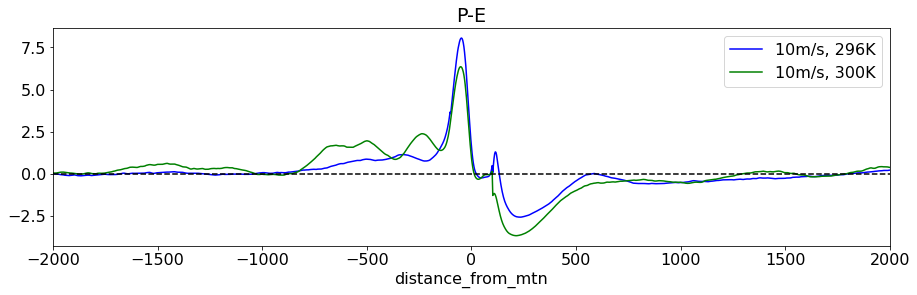

In [28]:
plt.figure(figsize=(15,4))
for Sim in W10S296,W10S300:
    (Sim.RAINNC_ALL_SECTION-Sim.EVAP).plot(color = Sim.color,label=Sim.label)
#    (Sim.RAINNC_ALL_SECTION-Sim.RAINNC_BASE).plot(color = Sim.color,linestyle='--')
plt.title("P-E")
plt.axhline(0.,color='k',linestyle='--')
plt.legend()
plt.xlim(-2000,2000)

In [38]:
for Sim in W10S296,W10S300:
    uq = (-Sim.U_PL_MEAN*Sim.Q_PL_MEAN)[::-1]
    uq_sfc = -Sim.Q2_MEAN*Sim.U10_MEAN
    uq_vinteg = xr.apply_ufunc(integrate,uq,uq.pressure,50,Sim.PSFC_MEAN/100,uq_sfc,input_core_dims=[['pressure'],['pressure'],[],[],[]],vectorize=True)*100/9.81
    uq_vinteg_smooth = xr.apply_ufunc(gaussian_filter1d,uq_vinteg,5)
    Sim.VIMC = -86400*uq_vinteg_smooth.differentiate('distance_from_mtn')/1000

In [52]:
for Sim in W10S296,W10S300:
    uq = (-Sim.U_PL_MEAN*Sim.Q_PL_MEAN.mean('distance_from_mtn'))[::-1]
    uq_sfc = -Sim.Q2_MEAN.mean('distance_from_mtn')*Sim.U10_MEAN
    uq_vinteg = xr.apply_ufunc(integrate,uq,uq.pressure,50,Sim.PSFC_MEAN/100,uq_sfc,input_core_dims=[['pressure'],['pressure'],[],[],[]],vectorize=True)*100/9.81
    uq_vinteg_smooth = xr.apply_ufunc(gaussian_filter1d,uq_vinteg,5)
    Sim.VIMCQZ = -86400*uq_vinteg_smooth.differentiate('distance_from_mtn')/1000

In [30]:
W10S296.color2 = 'c'
W10S300.color2 = 'limegreen'

(-2000.0, 2000.0)

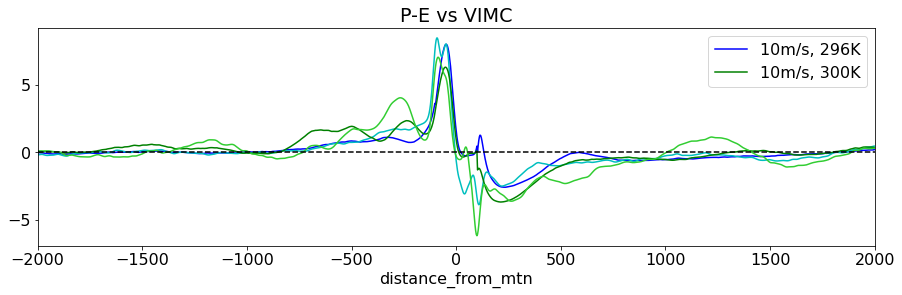

In [39]:
plt.figure(figsize=(15,4))
for Sim in W10S296,W10S300:
    (Sim.RAINNC_ALL_SECTION-Sim.EVAP).plot(color = Sim.color,label=Sim.label)
    Sim.VIMC.plot(color = Sim.color2)
plt.title("P-E vs VIMC")
plt.axhline(0.,color='k',linestyle='--')
plt.legend()
plt.xlim(-2000,2000)

(-2000.0, 2000.0)

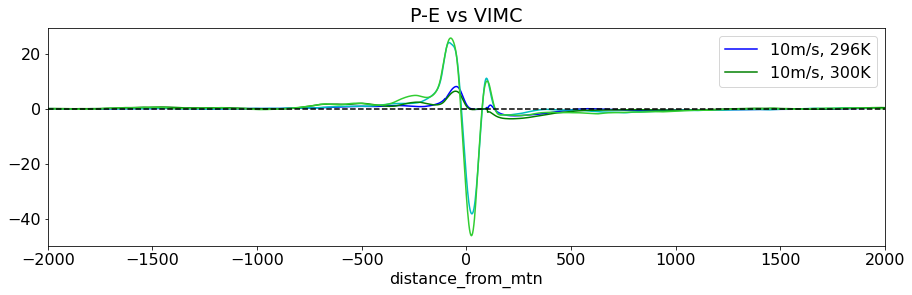

In [53]:
plt.figure(figsize=(15,4))
for Sim in W10S296,W10S300:
    (Sim.RAINNC_ALL_SECTION-Sim.EVAP).plot(color = Sim.color,label=Sim.label)
    Sim.VIMCQZ.plot(color = Sim.color2)
plt.title("P-E vs VIMC")
plt.axhline(0.,color='k',linestyle='--')
plt.legend()
plt.xlim(-2000,2000)

In [44]:
for Sim in W10S296,W10S300:
    uq = (-Sim.U_PL_MEAN*W10S296.Q_PL_MEAN)[::-1]
    uq_sfc = -Sim.U10_MEAN*W10S296.Q2_MEAN
    uq_vinteg = xr.apply_ufunc(integrate,uq,uq.pressure,50,Sim.PSFC_MEAN/100,uq_sfc,input_core_dims=[['pressure'],['pressure'],[],[],[]],vectorize=True)*100/9.81
    uq_vinteg_smooth = xr.apply_ufunc(gaussian_filter1d,uq_vinteg,5)
    Sim.VIMC_FIXQ = -86400*uq_vinteg_smooth.differentiate('distance_from_mtn')/1000

In [46]:
for Sim in W10S296,W10S300:
    uq = (-W10S296.U_PL_MEAN*Sim.Q_PL_MEAN)[::-1]
    uq_sfc = -W10S296.U10_MEAN*Sim.Q2_MEAN
    uq_vinteg = xr.apply_ufunc(integrate,uq,uq.pressure,50,Sim.PSFC_MEAN/100,uq_sfc,input_core_dims=[['pressure'],['pressure'],[],[],[]],vectorize=True)*100/9.81
    uq_vinteg_smooth = xr.apply_ufunc(gaussian_filter1d,uq_vinteg,5)
    Sim.VIMC_FIXU = -86400*uq_vinteg_smooth.differentiate('distance_from_mtn')/1000

(-2000.0, 2000.0)

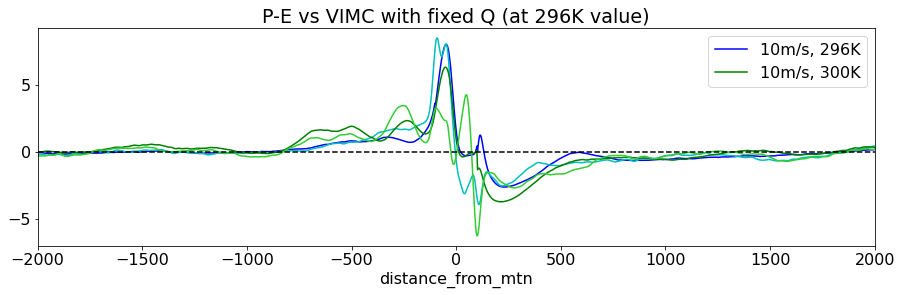

In [47]:
plt.figure(figsize=(15,4))
for Sim in W10S296,W10S300:
    (Sim.RAINNC_ALL_SECTION-Sim.EVAP).plot(color = Sim.color,label=Sim.label)
    Sim.VIMC_FIXQ.plot(color = Sim.color2)
plt.title("P-E vs VIMC with fixed Q (at 296K value)")
plt.axhline(0.,color='k',linestyle='--')
plt.legend()
plt.xlim(-2000,2000)

(-2000.0, 2000.0)

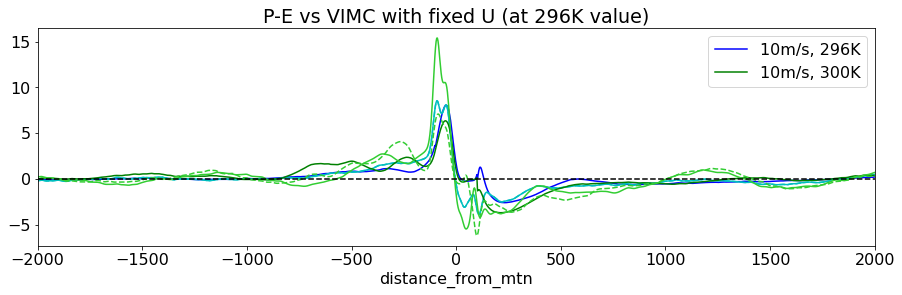

In [51]:
plt.figure(figsize=(15,4))
for Sim in W10S296,W10S300:
    (Sim.RAINNC_ALL_SECTION-Sim.EVAP).plot(color = Sim.color,label=Sim.label)
    Sim.VIMC_FIXU.plot(color = Sim.color2)
    Sim.VIMC.plot(color = Sim.color2,linestyle='--')
plt.title("P-E vs VIMC with fixed U (at 296K value)")
plt.axhline(0.,color='k',linestyle='--')
plt.legend()
plt.xlim(-2000,2000)

## Hourly

In [17]:
# for Sim in W10S296,W10S300:
#     uq_vintegc = xr.open_zarr(Sim.path+'wrf.VIWVE.1h.%s.zarr'%Sim.suffix2).VIWVE[1200:-1].mean(('Time','south_north')).load()
#     uq_vinteg_smooth = xr.apply_ufunc(gaussian_filter1d,uq_vintegc,5)
#     Sim.VIMC_tot = (-86400*uq_vinteg_smooth.differentiate('distance_from_mtn')/1000)
# for Sim in W10S296,W10S300:
#     uq_vintegc = xr.open_zarr(Sim.path+'wrf.VIWVE_WINTERPSFC.1h.%s.zarr'%Sim.suffix2).VIWVE[1200:-1].mean(('Time','south_north')).load()
#     uq_vinteg_smooth = xr.apply_ufunc(gaussian_filter1d,uq_vintegc,5)
#     Sim.VIMC2_tot = (-86400*uq_vinteg_smooth.differentiate('distance_from_mtn')/1000)

In [35]:
for Sim in W10S296,W10S300:
    uq_vintegc = xr.open_dataset(Sim.path+'wrf.VIWVE_WINTERPSFC.ALLMEAN.nc').VIWVE
    uq_vinteg_smooth = xr.apply_ufunc(gaussian_filter1d,uq_vintegc,5)
    Sim.VIMC_tot = (-86400*uq_vinteg_smooth.differentiate('distance_from_mtn')/1000)

(-2000.0, 2000.0)

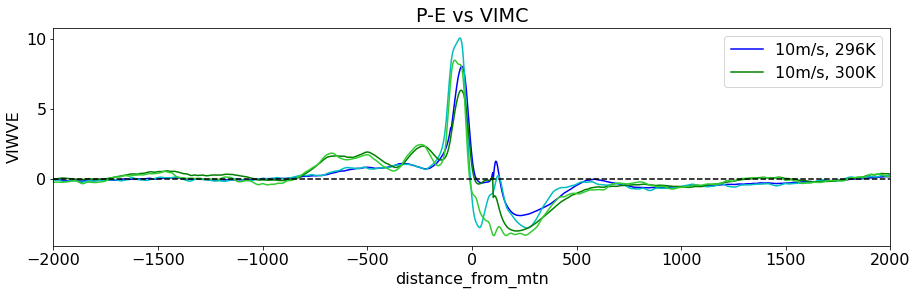

In [36]:
plt.figure(figsize=(15,4))
for Sim in W10S296,W10S300:
    (Sim.RAINNC_ALL_SECTION-Sim.EVAP).plot(color = Sim.color,label=Sim.label)
    Sim.VIMC_tot.plot(color = Sim.color2)
plt.title("P-E vs VIMC")
plt.axhline(0.,color='k',linestyle='--')
plt.legend()
plt.xlim(-2000,2000)

No handles with labels found to put in legend.


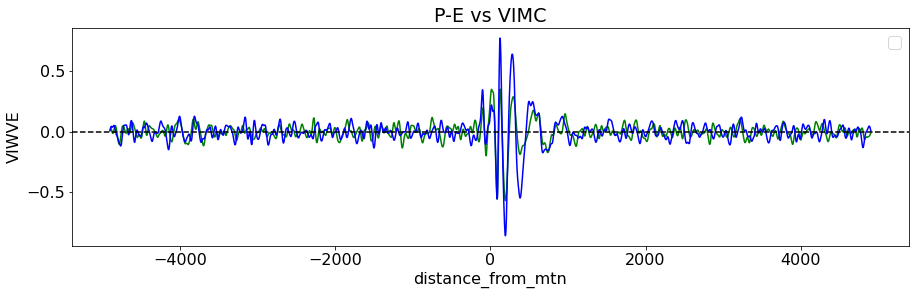

In [18]:
plt.figure(figsize=(15,4))
for Sim in W10S300,W10S296:
    (Sim.VIMC_tot-Sim.VIMC2_tot).plot(color = Sim.color)
    #(Sim.VIMC3_tot-Sim.VIMC2_tot).plot(color = Sim.color2)
plt.title("P-E vs VIMC")
plt.axhline(0.,color='k',linestyle='--')
plt.legend()
#plt.xlim(-2000,2000)

(-2000.0, 2000.0)

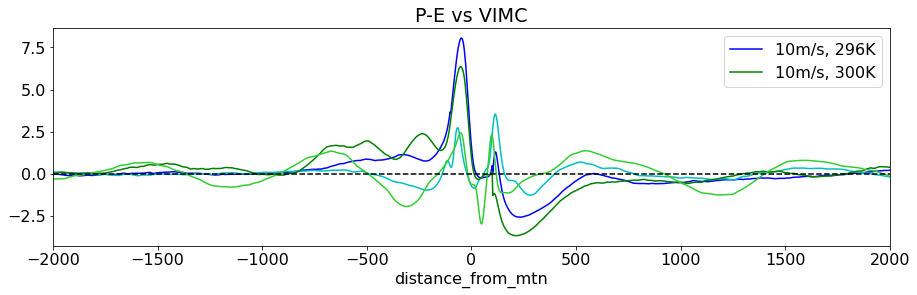

In [40]:
plt.figure(figsize=(15,4))
for Sim in W10S296,W10S300:
    (Sim.RAINNC_ALL_SECTION-Sim.EVAP).plot(color = Sim.color,label=Sim.label)
    (Sim.VIMC_tot-Sim.VIMC).plot(color = Sim.color2)
plt.title("P-E vs VIMC")
plt.axhline(0.,color='k',linestyle='--')
plt.legend()
plt.xlim(-2000,2000)